In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict



In [2]:
df = pd.read_csv('deaths_and_infections.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
new_deaths=np.array(df['new_deaths'])
death_cumul=np.array([sum(new_deaths[:i]) for i in range(len(new_deaths))])
dates_of_pandemic=np.arange(len(new_deaths))

Test of a single ARIMA model 

/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


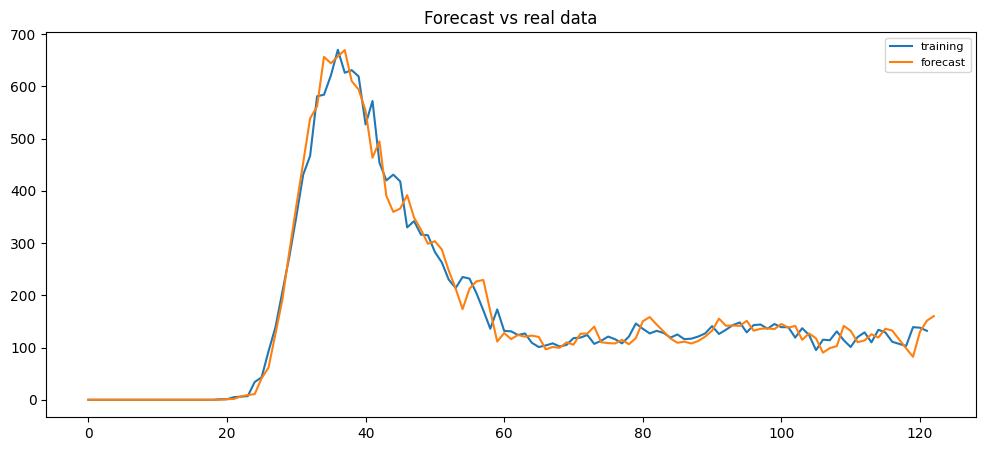

In [3]:
model = ARIMA(new_deaths, order=(4,4,4))  
fitted = model.fit()  
prediction=fitted.predict(start=0, end=len(new_deaths) , typ='levels')

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(new_deaths, label='training')
plt.plot(prediction, label='forecast')
plt.title('Forecast vs real data' )
plt.legend(loc='best', fontsize=8)
plt.show()

# set plot_verifs to True to plot the verifications
plot_verifs = False
if plot_verifs: 

    # on vérifir que les résidus sont bien du bruit blanc
    residuals = pd.DataFrame(fitted.resid)
    residuals.plot(title="Residuals")

    plt.show()
    residuals.plot(kind='kde', title='Density')
    plt.show()
    print(residuals.describe())
    # autocorrélation des résidus
    from pandas.plotting import autocorrelation_plot
    autocorrelation_plot(residuals)
    plt.show()



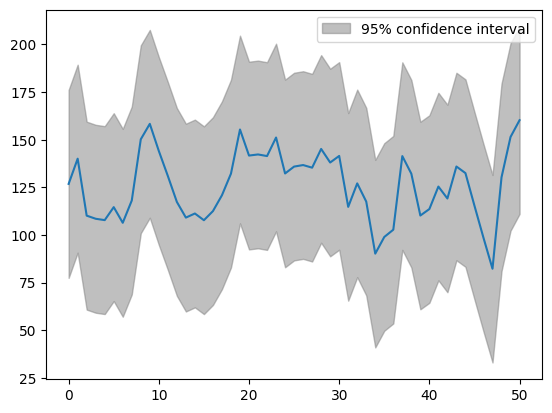

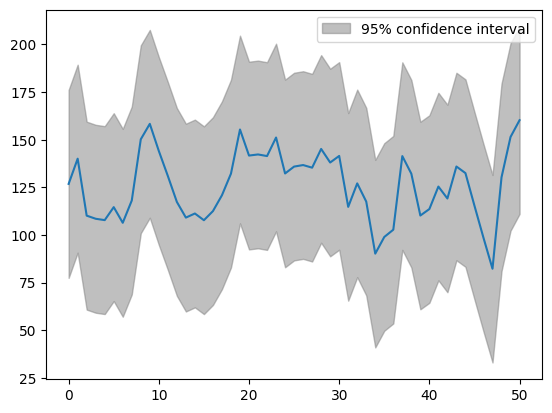

In [4]:
plot_predict(fitted, len(new_deaths) - 50, len(new_deaths) )   

In [7]:
min = 1000
pmin=0
dmin=0
qmin=0
for p in range(7): 
    print(p)
    for d in range(7): 
        for q in range(7): 
            if not (p,d,q) == (0,1,0):
                model = ARIMA(new_deaths, order=(p,d,q))  
                fitted = model.fit()  
                prediction=fitted.predict(start=1, end=len(new_deaths) , typ='levels')
                error = np.mean(np.abs(prediction - new_deaths))
                if error < min:
                    min = error
                    pmin=p
                    dmin=d
                    qmin=q
                    print('new combinaition')
                    print(p,d,q,min)
print(pmin,dmin,qmin,min)

0
new combinaition
0 0 0 115.25436582659712
new combinaition
0 0 1 63.42111410935559
new combinaition
0 0 2 40.997630560864096


/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


new combinaition
0 0 3 34.3299296492288
new combinaition
0 0 5 21.48661324587833
new combinaition
0 1 0 1.281306572682148e-15


/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check m

1


/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization f

2


/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/eleves-a/2021/gregoire.bechade/code_remote/.venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check m

LinAlgError: LU decomposition error.